<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/main/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickaël et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import (Conv2D,Dropout,Input,MaxPooling2D,concatenate,Conv2DTranspose,UpSampling2D)
from keras.layers.noise import GaussianNoise

### Download the dataset from internet and extract it on the system

**We resized all images to 562x562 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [3]:
zipurl = 'https://download1351.mediafire.com/gr6h5zd1roqg/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

## Extracting metadata from artist.csv and labelize genres

In [4]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
artists['name'][19]='Albrecht_Durer' #fix ASCII problems
tmp=artists['name']
name=[tmp[i].replace(' ','_') for i in range(len(tmp))]#replace space by underscore, more convinent to import images

##genre of artists
tmp=artists['genre']
genre=[tmp[i].replace(',','/') for i in range(len(tmp))]#replace coma by slash, avoid mistakes in list

##number of paintings by artists
nb_paints=artists['paintings']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Labelize a genre with a number

In [5]:
genre_label={'Expressionism':1,'Abstractionism':2,'Social Realism':3,'Muralism':4,'Impressionism':5,'Surrealism':6,'Byzantine Art':7,'Post-Impressionism':8,'Symbolism':9,'Art Nouveau':10,'Northern Renaissance':11,'Suprematism':12,'Cubism':13,'Baroque':14,'Romanticism':15,'Primitivism':16,'Mannerism':17,'Proto Renaissance':18,'Early Renaissance':19,'High Renaissance':20,'Neoplasticism':21,'Pop Art':22,'Abstract Expressionism':23}
#labelize a genre by a number

## Append all artworks in a list (for later)

In [ ]:
#artworks=[]#list of [img,artist,genre]
#for i in range(len(name)):
#  for j in range(nb_paints[i]):
#    data=[plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'),name[i],genre[i]] #[img,artist,genre]
#    artworks.append(data)

## Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [6]:
artworks=[]
genre1=(3,14,15,20,25,27,31) #~50/50 impressionism/Baroque
for i in genre1:
  for j in range(nb_paints[i]):
    data=[plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'),name[i],genre[i]] #[img,artist,genre]
    artworks.append(data)

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Rembrandt,\nBaroque')

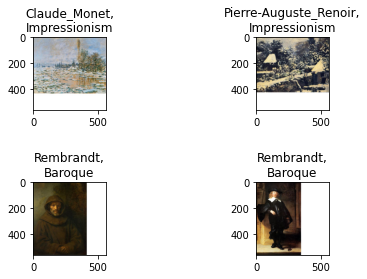

In [7]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[1][0])
plt.title(f'{artworks[1][1]},\n{artworks[1][2]}')
plt.subplot(222)
plt.imshow(artworks[300][0])
plt.title(f'{artworks[300][1]},\n{artworks[300][2]}')
plt.subplot(223)
plt.imshow(artworks[-1][0])
plt.title(f'{artworks[-1][1]},\n{artworks[-1][2]}')
plt.subplot(224)
plt.imshow(artworks[-200][0])
plt.title(f'{artworks[-200][1]},\n{artworks[-200][2]}')

## split of the dataset

In [ ]:
np.random.shuffle(artworks) #shuffle the dataset

In [ ]:
paintings=[i[0] for i in artworks]
genre_paintings=[genre_label[i[2]] for i in artworks]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(paintings,genre_paintings, test_size=0.33, random_state=42)